# Trabalho Prático 1: Geometria Computacional

Filipe Pirola Santos - 2021031580

Igor Eduardo Martins Braga - 2022425671

Wallace Eduardo Pereira - 2021032013

# Bibliotecas


In [88]:
pip install ucimlrepo

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 23.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [89]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import seaborn as sns
from ucimlrepo import fetch_ucirepo

# Manipulando, limpando e plotando datasets

Nessa parte do trabalho importamos datasets dos sites propostos na documentação e os manipulamos para tornarem-nos apropriados para utilização no modelo de classificação proposto.

Para isso, quando o dataset é composto por varias classes (targets), o diminuimos para dois somente a partir da junção dessas classes ou remoção de algumas delas.    

**Função de plotagem dos gráficos**

In [90]:
def plot_scatter(dataframe):

    sns.scatterplot(data=dataframe, x='X', y='Y', hue='Class', alpha=0.6, palette="deep")

    plt.xlabel('X')
    plt.ylabel('Y')
    plt.legend()

    plt.show()

**Função de importação de datasets do site UC Irvine**

In [91]:
def import_uci(id):
    dataframe = fetch_ucirepo(id=id)
    features = dataframe.data.features 
    targets = dataframe.data.targets
    return features, targets

### 1 - Dataset Iris - Separável

Link: https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_iris.html#sklearn.datasets.load_iris

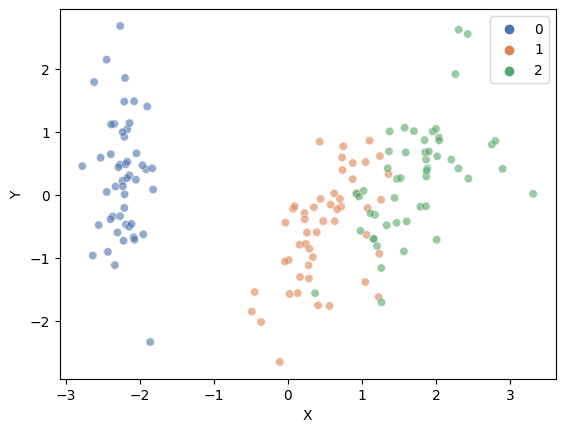

In [92]:
from sklearn.datasets import load_iris

# Carregando dataset
iris = load_iris()

iris_data = iris.data

# Normalizando os dados
normalized_data = StandardScaler().fit_transform(iris_data)

# Aplicando a técnica de PCA para reduzir o dataset para duas dimensões
pca = PCA(n_components=2)
components = pca.fit_transform(normalized_data)
iris_df = pd.DataFrame(data=components, columns=["X","Y"])

# Adicionando coluna de classe (target) no dataset reduzido dimensionalmente
iris_df['Class'] = iris.target

plot_scatter(iris_df)

Percebemos que há três classes nesse dadaset e que os pontos de duas delas dividem o mesmo plano. Logo, para tornar o dataset apropriado para o trabalho, basta remover uma das classes que se convergem. Aqui, decidimos remover a classe 2

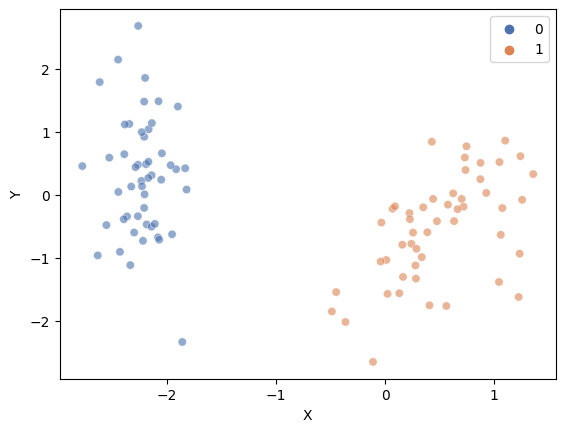

In [93]:
# Remove a classe 2 do dataset
iris_filtered = iris_df[iris_df['Class'] != 2]

plot_scatter(iris_filtered)

Entendemos que, dessa maneira, os dois grupos se tornaram linearmente separáveis. Portanto, agora podemos dividir os dados em conjuntos de teste e treinamento.

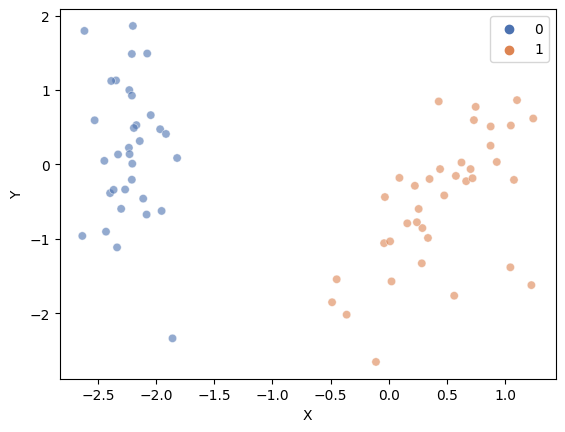

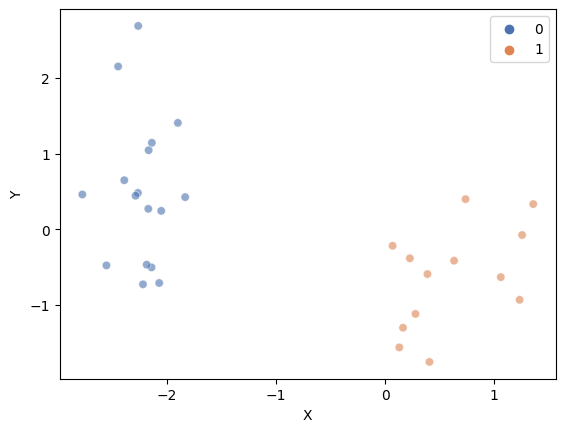

In [94]:
# Separa os dados em teste e treinamento
train_data, test_data = train_test_split(iris_filtered, test_size=0.3, random_state=42)

plot_scatter(train_data)
plot_scatter(test_data)

### 2 - Dataset Wine - Separável

Link: https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_wine.html#sklearn.datasets.load_wine

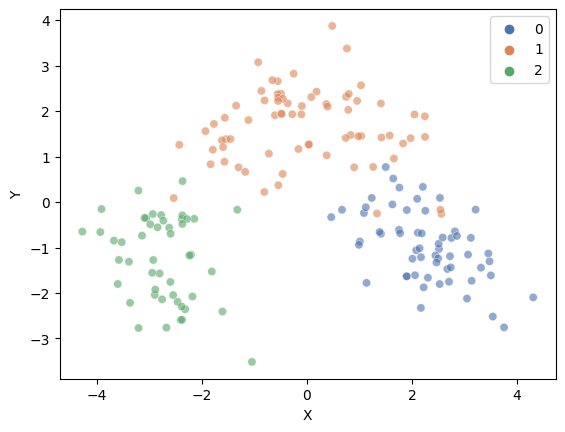

In [95]:
from sklearn.datasets import load_wine

# Carrega o banco
wine = load_wine()
wine_data = wine.data

# Reduz o dataframe para duas dimensões usando a técnica de PCA
pca = PCA(n_components=2)
normalized_data = StandardScaler().fit_transform(wine_data)
componentes = pca.fit_transform(normalized_data)
wine_df = pd.DataFrame(data=componentes, columns=["X","Y"])

# Adiciona a coluna de classe (target) no banco reduzido dimensionalmente
wine_df['Class'] = wine.target

plot_scatter(wine_df)

Percebemos novamente que alguns dos grupos de pontos se convergem. Dessa vez, para torná-los separáveis, podemos remover o grupo 1

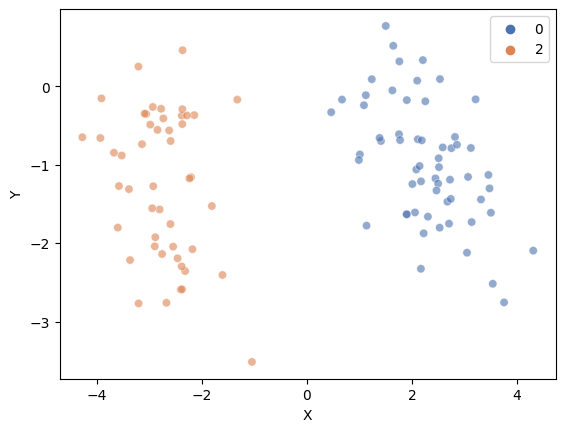

In [96]:
# Remove o grupo 1 do dataset
wine_filtered = wine_df[wine_df['Class'] != 1]

plot_scatter(wine_filtered)

Entendemos que, dessa maneira, os dois grupos se tornaram linearmente separáveis. Portanto, agora podemos dividir os dados em conjuntos de teste e treinamento.

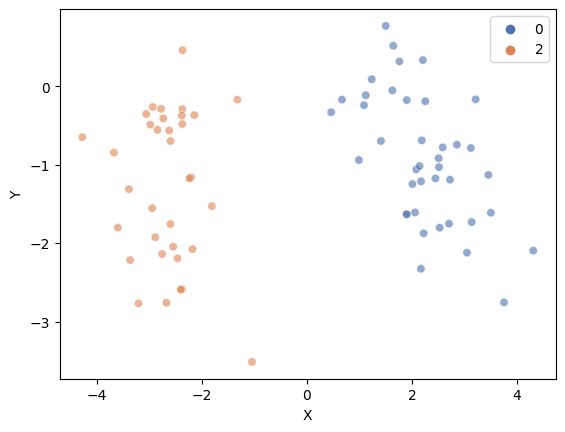

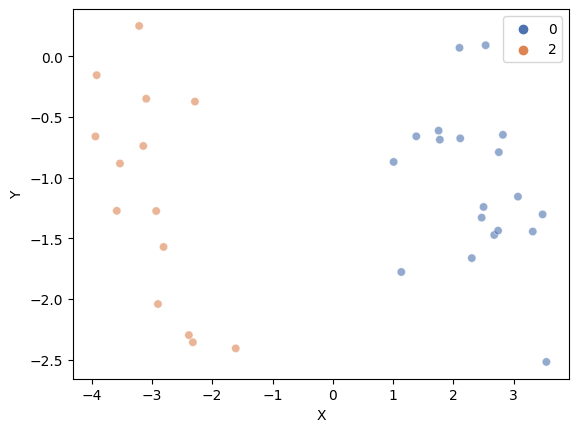

In [97]:
train_data, test_data = train_test_split(wine_filtered, test_size=0.3, random_state=42)

plot_scatter(train_data)
plot_scatter(test_data)

### 3 - Digits DataSet - Separável (Manipulado)

Link: https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_digits.html#sklearn.datasets.load_digits

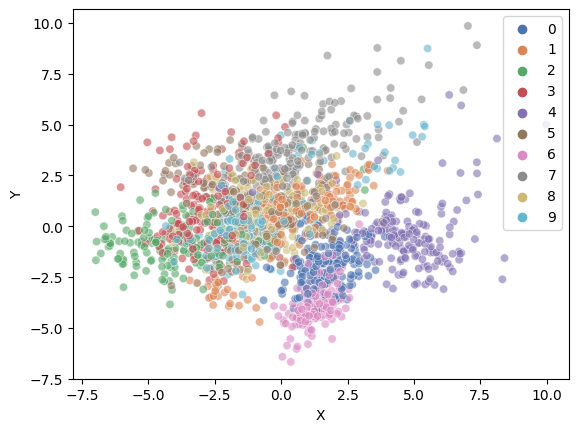

In [210]:
from sklearn.datasets import load_digits

# Carregando dataset
digits = load_digits()
digits_data = digits.data

# Reduzindo dataset para duas dimensões
pca = PCA(n_components=2)
normalized_data = StandardScaler().fit_transform(digits_data)
componentes = pca.fit_transform(normalized_data)
digits_df = pd.DataFrame(data=componentes, columns=["X","Y"])

# Adiciona a coluna de classe (target) no banco reduzido dimensionalmente
digits_df['Class'] = digits.target

plot_scatter(digits_df)

Ao fazer uma análise mais a fundo sobre esse dataset, percebemos que ha dois grupos de dados que podem se tornar linearmente separáveis. Um formado pelas classe 1 e o outro formado pela classe 7. Decidimos usar somente duas classes para poder observar bem o funcionamento do nosso modelo com as retas de menor distância entre as envoltórias e a reta perpendicular à essa bem aparentes.

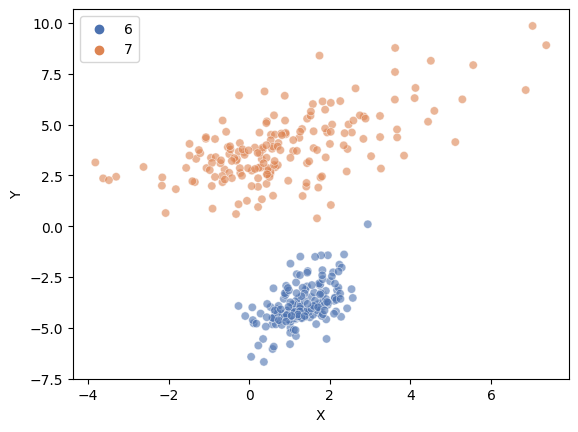

In [211]:
# Separando os dados que formam os 2 grupos
digits_filtered = digits_df[(digits_df['Class'] == 6) | (digits_df['Class'] == 7)]

plot_scatter(digits_filtered)

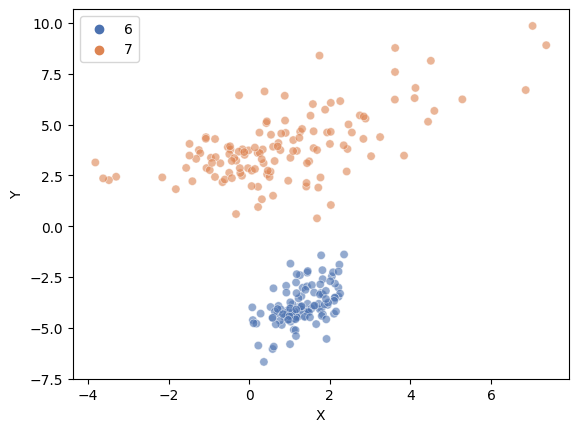

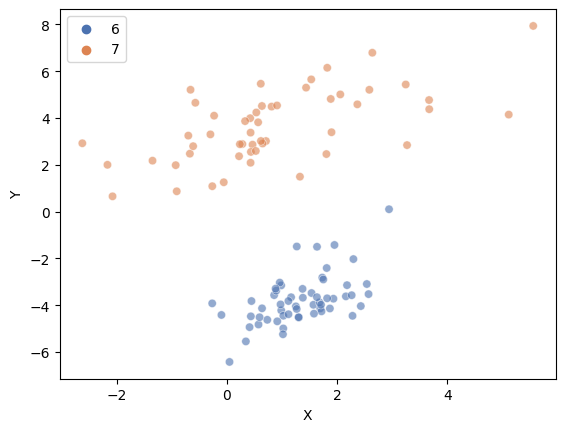

In [212]:
# Separando em dados de treino e teste
train_data, test_data = train_test_split(digits_filtered, test_size=0.3, random_state=10)

plot_scatter(train_data)
plot_scatter(test_data)

### 4 - Breast Cancer DataSet - Separável (Manipulado)

Link: https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_breast_cancer.html#sklearn.datasets.load_breast_cancer

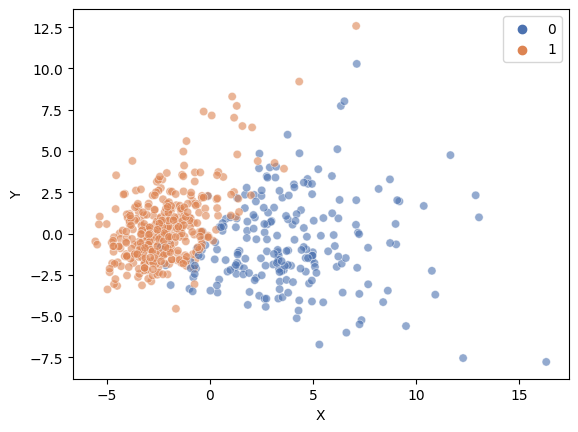

In [101]:
from sklearn.datasets import load_breast_cancer

breast_cancer = load_breast_cancer()
breast_cancer_data = breast_cancer.data

pca = PCA(n_components=2)
normalized_data = StandardScaler().fit_transform(breast_cancer_data)
componentes = pca.fit_transform(normalized_data)
breast_cancer_df = pd.DataFrame(data=componentes, columns=["X","Y"])

breast_cancer_df['Class'] = breast_cancer.target

plot_scatter(breast_cancer_df)

Percebemos que há duas classes diferentes. A partir disso, também observamos que é possivel tornar os dados linearmente separaveis excluindo alguns pontos da classe 0. Para isso, selecionamos o ponto mais à direita da classe 1 e apagamos todos os pontos da classe 0 que estão à esquerda desse ponto selecionado. Depois de fazer essa limpeza de dados ainda percebemos que havia dois pontos colineares entre as classes. Percebemos que um dele era o mais extremo se tratando do eixo Y. Assim, selecionamos esse ponto e o removemos. Depois disso, os dois conjuntos se tornaram linearmente separáveis.

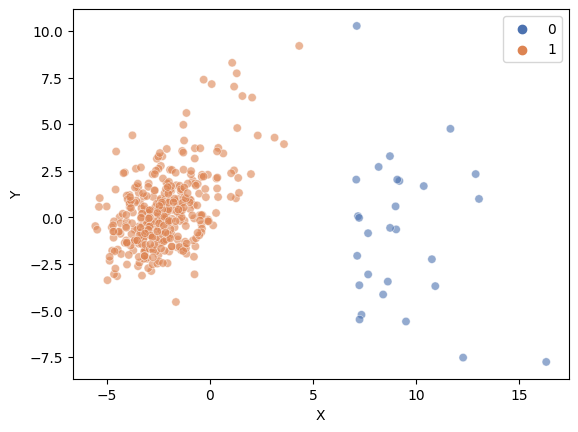

In [102]:
# Pegando o ponto mais à direita da classe 1
right_point = breast_cancer_df[breast_cancer_df['Class'] == 1].max()['X']

# Apagar pontos da classe 0 que estão à esquerda do ponto mais à direita da classe 1
filtered_breast_cancer = breast_cancer_df[(breast_cancer_df['Class'] != 0) | (breast_cancer_df['X'] >= right_point)]

# Encontrar o ponto mais acima (eixo Y) da classe 1
highest_y = filtered_breast_cancer[filtered_breast_cancer['Class'] == 1]['Y'].max()

# Apagar ponto mais acima encontrado
filtered_breast_cancer = filtered_breast_cancer.drop(filtered_breast_cancer[(filtered_breast_cancer['Class'] == 1) & (filtered_breast_cancer['Y'] == highest_y)].index)

plot_scatter(filtered_breast_cancer)

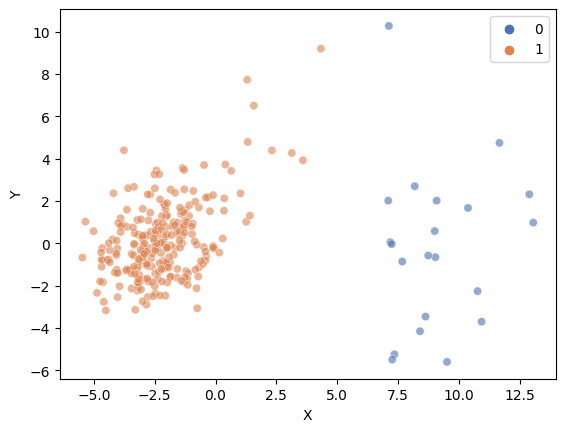

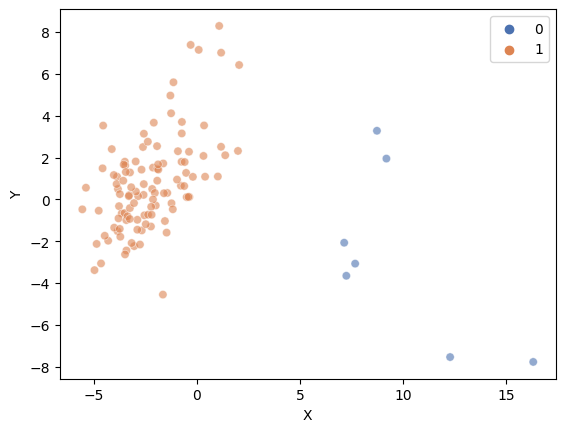

In [103]:
# Separando os dados em treinamento e teste
train_data, test_data = train_test_split(filtered_breast_cancer, test_size=0.3, random_state=42)

plot_scatter(train_data)
plot_scatter(test_data)

### 5 - Rice DataSet - Separável (Manipulado)

Link: https://archive.ics.uci.edu/dataset/545/rice+cammeo+and+osmancik

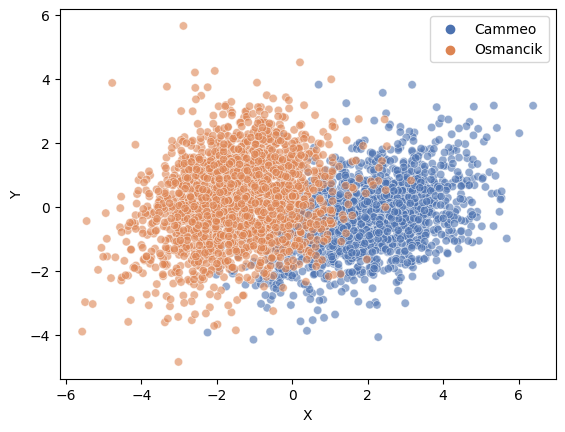

In [104]:
features, targets = import_uci(545)

normalized_data = StandardScaler().fit_transform(features)

# Apply PCA with 2 components
pca = PCA(n_components=2)
components = pca.fit_transform(normalized_data)

# Create a dataframe with PCA components and class labels
rice_df = pd.DataFrame(data=components, columns=["X", "Y"])
rice_df['Class'] = targets

plot_scatter(rice_df)


Percebemos novamente que há convergencia entre pontos das duas classes. Assim, utilizamos a mesma ideia do ultimo dataset manipulado, selecionamos o ponto mais à esqueda da classe "Cammeo" e a partir dele, apagamos todos os pontos mais à direita desse ponto que pertencem à classe Osmancik.

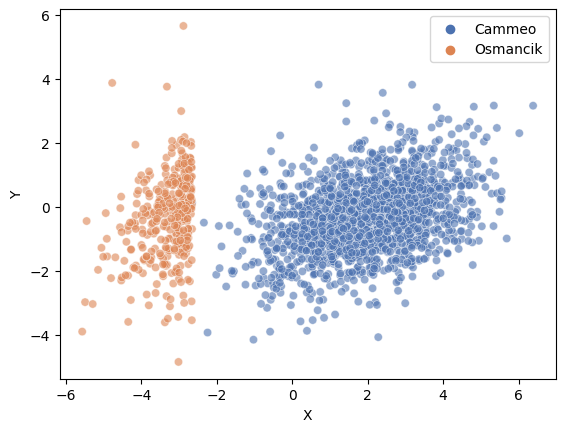

In [105]:
# Selecionar ponto mais à esqueda da classe "Cammeo"
cammeo_leftmost_point = rice_df[rice_df['Class'] == 'Cammeo'].min()['X']

# Apagar todos os pontos à direita da classe "Osmancik" do ponto mais à esquerda da classe "Cammeo"
filtered_rice_df = rice_df[(rice_df['Class'] != 'Osmancik') | (rice_df['X'] <= cammeo_leftmost_point)]

plot_scatter(filtered_rice_df)

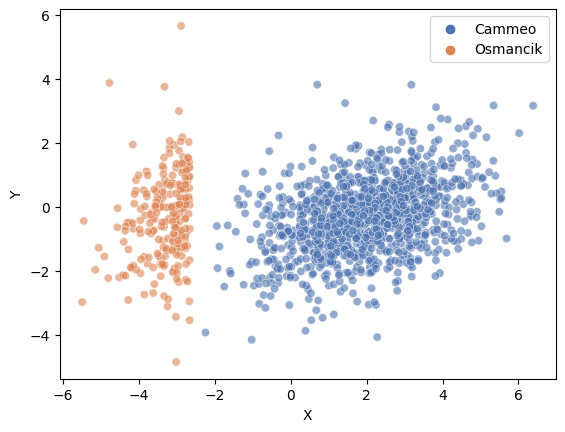

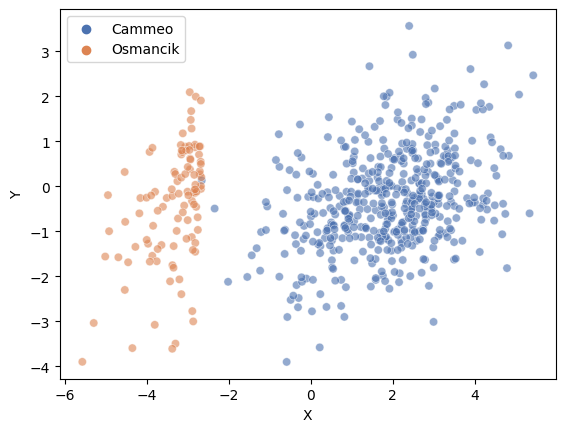

In [121]:
# Separando os dados em treinamento e teste
train_data, test_data = train_test_split(filtered_rice_df, test_size=0.3, random_state=50)

plot_scatter(train_data)
plot_scatter(test_data)

### 6 - Lung Cancer DataSet - Separável (Manipulado)

Link: https://archive.ics.uci.edu/dataset/62/lung+cancer

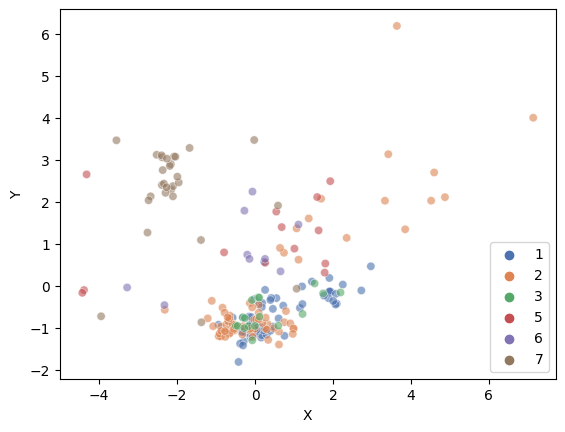

In [107]:
features, targets = import_uci(42)

normalized_data = StandardScaler().fit_transform(features)

# Apply PCA with 2 components
pca = PCA(n_components=2)
components = pca.fit_transform(normalized_data)

# Create a dataframe with PCA components and class labels
lung_cancer_df = pd.DataFrame(data=components, columns=["X", "Y"])
lung_cancer_df['Class'] = targets

plot_scatter(lung_cancer_df)

Percebemos que é póssivel separar os dados em duas classes diferentes. Para isso, primeiramente, escolhemos somente as classes 7, 1 e 3 para fazerem parte do dataframe, como mostrado abaixo:

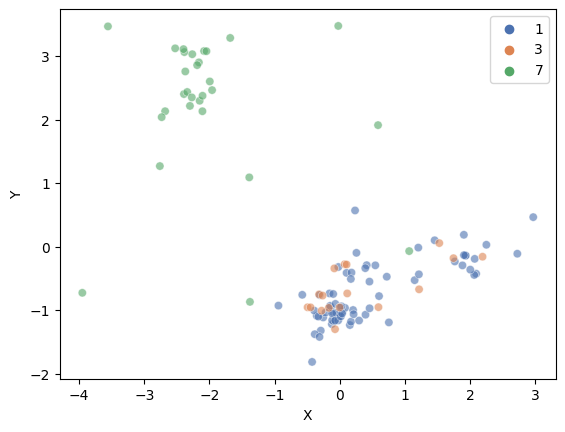

In [108]:
# Seleciona as classes 7, 1 e 3 do dataframe
lung_cancer_df = lung_cancer_df[(lung_cancer_df['Class'] == 7) | (lung_cancer_df['Class'] == 1) | (lung_cancer_df['Class'] == 3)]

plot_scatter(lung_cancer_df)

Após isso, classificamos os pontos das classes 1 e 3 de "Other Group". Além disso, removemos o ponto mais à direita referente à classe 7, pois ele estava impedindo a separação linear dos grupos. Assim, ficamos com dois rótulos em nosso dataframe: 7 e Other Group.

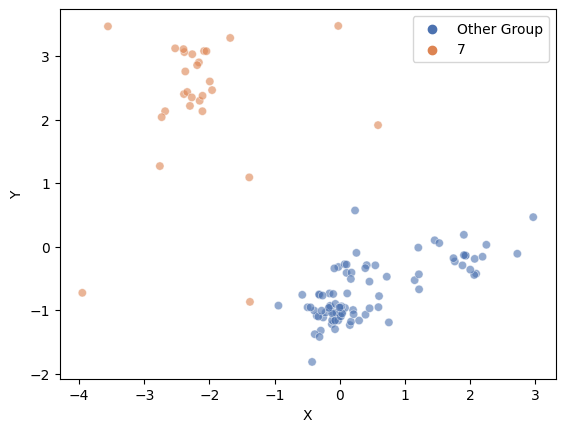

In [109]:
# Fazer uma cópia do dataframe
new_lung_cancer_df = lung_cancer_df.copy()

# Classificar todos os pontos diferentes da classe 7 de "Other Group"
new_lung_cancer_df.loc[new_lung_cancer_df['Class'] != 7, 'Class'] = "Other Group"

# Selecionar ponto mais à direita da classe 7
rightmost_point = new_lung_cancer_df[new_lung_cancer_df['Class'] == 7].max()['X']

# Remover o ponto mais à direita da classe 7
lung_cancer_filtered = new_lung_cancer_df.drop(new_lung_cancer_df[(new_lung_cancer_df['Class'] == 7) & (new_lung_cancer_df['X'] == rightmost_point)].index)

plot_scatter(lung_cancer_filtered)

### 7 - Dry Bean DataSet - Separável (Manipulado)

Link: https://archive.ics.uci.edu/dataset/602/dry+bean+dataset

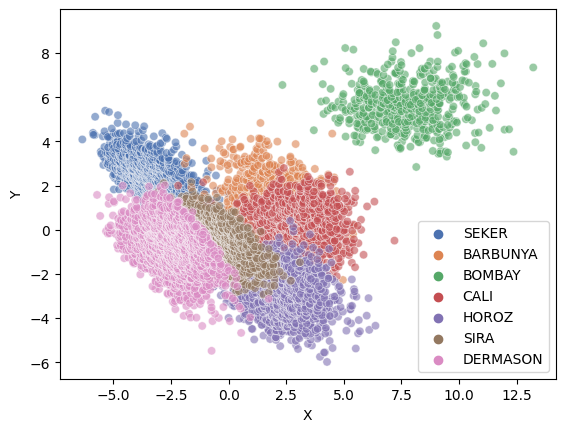

In [111]:
features, targets = import_uci(602)

normalized_data = StandardScaler().fit_transform(features)

# Apply PCA with 2 components
pca = PCA(n_components=2)
components = pca.fit_transform(normalized_data)

# Create a dataframe with PCA components and class labels
dry_bean_df = pd.DataFrame(data=components, columns=["X", "Y"])
dry_bean_df['Class'] = targets

plot_scatter(dry_bean_df)

Percebemos que há dois grandes grupos de dados. Um da esquerda que é composto pelas classes SEKER, BARBUNYA, CALI, HOROZ, SIRA e DERMASON e um da direita composto pela classe BOMBAY. Após isso, percebemos que a classe BARBUNYA estava convergindo com a classe BOMBAY e decidimos exclui-la do dataframe. Concomitantemente, classificamos todas as classes diferentes de BOMBAY de "Other Group". Assim, nossos dados ficaram prontos para aplicação do modelo

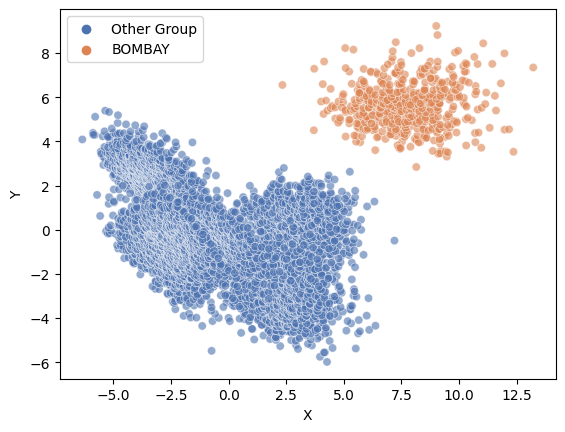

In [112]:
# Removendo classe "BARBUNYA" do dataFrame
dry_bean_df = dry_bean_df[dry_bean_df['Class'] != "BARBUNYA"]

# Criando cópia do dataframe para fazer alterações
dry_bean_df_filtered = dry_bean_df.copy()

# Classificar todos os pontos diferentes da classe "BOMBAY" de "Other Group"
dry_bean_df_filtered.loc[dry_bean_df_filtered['Class'] != "BOMBAY", 'Class'] = "Other Group"

plot_scatter(dry_bean_df_filtered)

### 8 - Olivetti DataSet - Não separável

Link: https://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_olivetti_faces.html#sklearn.datasets.fetch_olivetti_faces

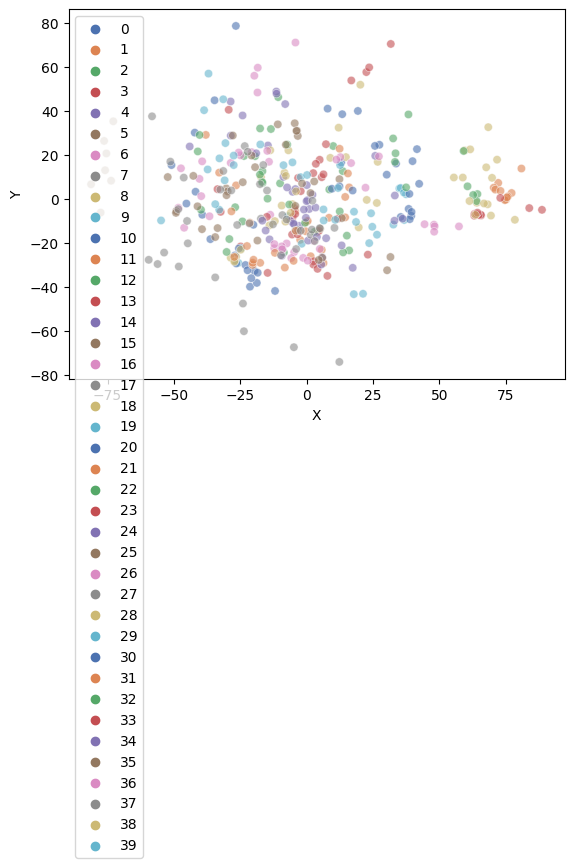

In [193]:
from sklearn.datasets import fetch_olivetti_faces

# Carregando dataset
olivetti_faces = fetch_olivetti_faces()

olivetti_faces_data = olivetti_faces.data

# Normalizando dados
normalized_data = StandardScaler().fit_transform(olivetti_faces_data)

# Aplicando a técnica de PCA para reduzir o dataset para duas dimensões
pca = PCA(n_components=2)
components = pca.fit_transform(normalized_data)
olivetti_faces_df = pd.DataFrame(data=components, columns=["X","Y"])

# Adicionando coluna de classe (target) no dataset reduzido dimensionalmente
olivetti_faces_df['Class'] = olivetti_faces.target

plot_scatter(olivetti_faces_df)

Percebemos que os dados se convergem muito e seria custoso torná-los separáveis manualmente (é possível torná-los separáveis, mas isso acarretaria muita perda de informação, já que seria necessário excluir um conjunto grande de pontos). Logo, decidimos usá-lo como não separável para testar nosso algoritmo de separabilidade linear.

Para usar esse dataset no modelo proposto, devemos separar os dados em dois rótulos. Assim, escolhemos duas classes (1 e 4) que formassem pontos que são não linearmente separáveis para que o algoritmo trabalhasse em cima desse caso.

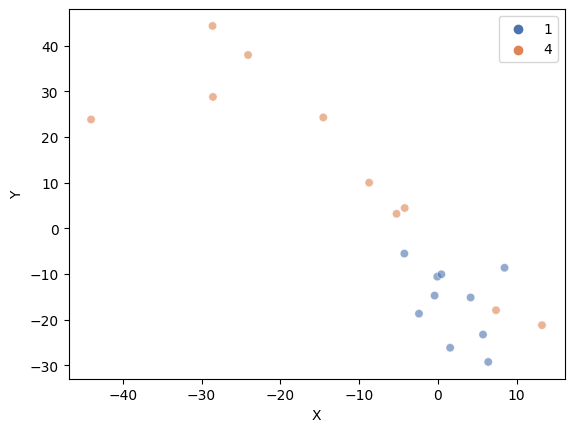

In [209]:
olivetti_faces_filtered = olivetti_faces_df[(olivetti_faces_df["Class"] == 4) | (olivetti_faces_df["Class"] == 1)]

plot_scatter(olivetti_faces_filtered)

### 9 - Letter Recognition DataSet

Link: https://archive.ics.uci.edu/dataset/59/letter+recognition

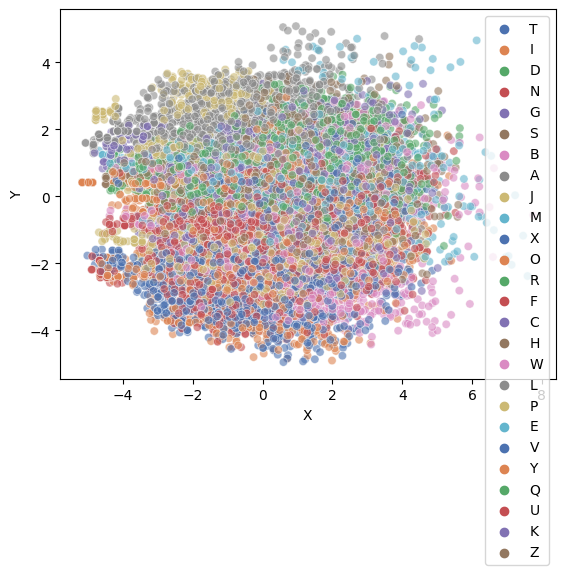

In [138]:
features, targets = import_uci(59)

normalized_data = StandardScaler().fit_transform(features)

# Aplicando a técnica de PCA para reduzir o dataset para duas dimensões
pca = PCA(n_components=2)
components = pca.fit_transform(normalized_data)
letter_recognition_df = pd.DataFrame(data=components, columns=["X","Y"])

letter_recognition_df['Class'] = targets

plot_scatter(letter_recognition_df)

Percebemos, após análises desse banco de dados, que pelo menos duas das classes têm algum ponto que divide o mesmo plano, impedindo que sejam traçadas envoltórias convexas sem que elas se encontrassem. Logo, decidimos usá-lo como não separável para testar nosso algoritmo